In [ ]:
print(1+2)

3


In [5]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.second_q.circuit.library import UCC

from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator


In [6]:

# -------------------------------------------------------
distances = np.linspace(0.3, 3, 30)
vqe_energies = []

for R in distances:

    driver = PySCFDriver(atom=f"H 0 0 0; H 0 0 {R}", basis="sto3g")
    problem = driver.run()

    transformer = ActiveSpaceTransformer(2, 2)
    problem = transformer.transform(problem)

    mapper = ParityMapper(num_particles=problem.num_particles)

    ansatz = UCC(
        num_spatial_orbitals=problem.num_spatial_orbitals,
        num_particles=problem.num_particles,
        excitations="sd"
    )

    estimator = Estimator()
    optimizer = SLSQP(maxiter=200)

    vqe_solver = VQEUCCFactory(estimator=estimator, ansatz=ansatz, optimizer=optimizer)
    calc_vqe = GroundStateEigensolver(mapper, vqe_solver)

    # VQE
    result_vqe = calc_vqe.solve(problem)
    vqe_energies.append(result_vqe.total_energies[0])


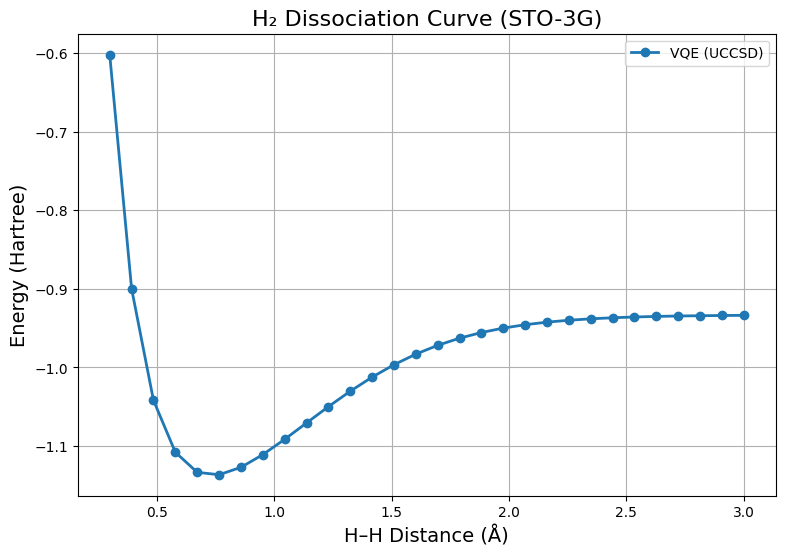

In [7]:

# ---------- Plot ----------
plt.figure(figsize=(9,6))
plt.plot(distances, vqe_energies, "o-", label="VQE (UCCSD)", linewidth=2)
plt.xlabel("H–H Distance (Å)", fontsize=14)
plt.ylabel("Energy (Hartree)", fontsize=14)
plt.title("H₂ Dissociation Curve (STO-3G)", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


In [9]:
d = np.argmin(vqe_energies)
print(d)

5


In [10]:
import numpy as np

from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA

from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import ParityMapper


# ===============================
# 1. Molecular Hamiltonian
# ===============================
R = 0.74   # H-H equilibrium bond length

driver = PySCFDriver(
    atom=f"H 0 0 0; H 0 0 {R}",
    basis="sto3g"
)
problem = driver.run()

# Active space (2 electrons, 2 orbitals)
transformer = ActiveSpaceTransformer(2, 2)
problem = transformer.transform(problem)

particle_number = problem.num_particles            # tuple (1, 1)
num_spatial_orbitals = problem.num_spatial_orbitals  # integer

mapper = ParityMapper(num_particles=particle_number)

h2_op = problem.hamiltonian.second_q_op()
qubit_op = mapper.map(h2_op)


# ===============================
# 2. HF Reference + UCCSD Ansatz
# ===============================
reference = HartreeFock(
    particle_number,          # (1, 1)
    num_spatial_orbitals,     # integer
    mapper
)

ansatz = UCCSD(
    num_particles=particle_number,
    num_spatial_orbitals=num_spatial_orbitals,
    qubit_mapper=mapper,
    initial_state=reference
)


# ===============================
# 3. VQE Solver
# ===============================
estimator = Estimator()
optimizer = COBYLA(maxiter=200)

vqe = VQE(
    ansatz=ansatz,
    estimator=estimator,
    optimizer=optimizer
)

result = vqe.compute_minimum_eigenvalue(qubit_op)
energy = float(result.eigenvalue.real)

print("\n===============================")
print("     H₂ Ground-State Energy")
print("===============================")
print(f"Bond distance: {R} Å")
print(f"Ground-state energy (VQE): {energy:.6f} Hartree")
print("===============================\n")


TypeError: '<=' not supported between instances of 'tuple' and 'int'